# Moving window dispersion functions


This tool is a generic moving window - dispersion function / variogram calculation tool,
implemented as a gernalized version of Mälicke et al. (2020).

> Mälicke, M., Hassler, S. K., Blume, T., Weiler, M., & Zehe, E. (2020). Soil moisture: variable in space but redundant in time. Hydrology and Earth System Sciences, 24(5), 2633-2653.

In [4]:
from toolbox_runner import list_tools
from pprint import pprint

tools = list_tools(prefix="ghcr.io/vforwater/tbr_", as_dict=True)
pprint(tools)

{'convert-input': convert-input: Convert input data  FROM ghcr.io/vforwater/tbr_moving_dispersion:main VERSION: 1.0,
 'moving-window': moving-window: Moving window variograms  FROM ghcr.io/vforwater/tbr_moving_dispersion:main VERSION: 1.0}


## Input Data

Load some input data from the aforementioned publication

In [1]:
import pandas as pd

In [8]:
positions = pd.read_csv('in/tutorial_pos.csv')
positions.head()

,x,y,d
0,53693.837759,98752.205367,pos_32
1,53693.837759,98752.205367,pos_33
2,53693.837759,98752.205367,pos_34
3,53691.342952,98749.025185,pos_35
4,53665.550000,98779.541089,pos_90


In [3]:
data = pd.read_csv('in/data.csv')
data.head()

,pos_33,pos_91,pos_94,pos_150,pos_153,pos_209,pos_271,pos_274,pos_386,pos_389,...,pos_945,pos_994,pos_997,pos_1000,pos_1062,pos_1124,pos_1127,pos_1189,pos_1192,pos_1248
0,0.250528,0.270215,0.194372,0.242260,0.231816,0.232861,0.318045,0.229118,0.180309,0.239628,...,0.376385,0.222115,NaN,0.221941,NaN,NaN,NaN,NaN,NaN,NaN
1,0.244556,0.270573,0.194483,0.242351,0.232788,0.231840,0.313242,0.228213,0.179354,0.242799,...,0.532000,0.217823,NaN,0.218455,NaN,NaN,NaN,NaN,NaN,NaN
2,0.240128,0.267462,0.192646,0.240201,0.230847,0.228955,NaN,NaN,0.177625,0.238312,...,0.517097,0.215962,NaN,0.215372,NaN,NaN,NaN,NaN,NaN,NaN
3,0.238337,0.266007,0.191451,0.239229,0.229830,0.227538,NaN,NaN,0.176472,0.237788,...,0.205288,0.214785,NaN,0.213372,NaN,NaN,NaN,NaN,NaN,NaN
4,0.236278,0.264618,0.190465,0.238118,0.228979,0.225990,NaN,NaN,0.175160,0.236997,...,0.192451,0.212799,NaN,0.211497,NaN,NaN,NaN,NaN,NaN,NaN


## Convert the input data

The actual moving window tool operates just on ordered array data. The ordering can originate from a time series but it doesn't have to. 
For convenience, there is a conversion tool included, that can take a CSV of positions and a CSV of data ordered in columns.
It will align the column names with the first, non-coordinate column in the positions. If there is no such column, the same order as in the columns is assumed, therefore it is recommended to align the data yourself.

In [10]:
converter = tools.get('convert-input')
step = converter.run(result_path='./test', positions=positions, data=data)

In [12]:
step.outputs

['STDERR.log', 'STDOUT.log', 'data.dat', 'positions.dat']

In [14]:
# get out the aligned data and positions
datarray = step.get('data.dat')
posarray = step.get('positions.dat')

print(datarray.shape)
print(posarray.shape)

(57, 1461)
(57, 2)


As you can see, there are 57 locations and the shapes are matching now. This is the format the actual tool needs.

# Moving Window

Run a 30-step moving window and calculate a variogram with some fixed parameters on each step. We can reuse some parameters from the Mälicke et al. (2020) publication

In [15]:
window = tools.get('moving-window')

# set the variogram
variogram = dict(n_lags=5, model="exponential", maxlag="median", estimator="cressie")

# run
step = window.run(result_path="./test", positions=posarray, data=datarray, variogram=variogram, window_size=30)

In [19]:
print(step.outputs)

['STDERR.log', 'STDOUT.log', 'data.dat', 'empirical_variograms.dat', 'empirical_variograms.json', 'positions.dat', 'variogram_parameters.dat']


The output contains two different representations: the empirical variograms as `.dat` with only the experimental value, or as `.json` which also includes the bins for each window.

The `variogram_parameters.dat` contain a series of variogram parameters

<AxesSubplot:>

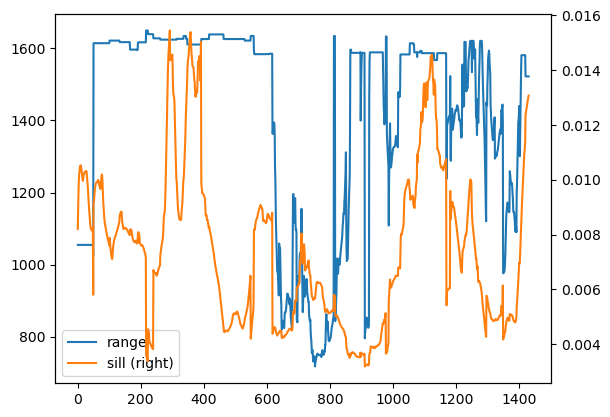

In [22]:
params = step.get('variogram_parameters.dat')

df = pd.DataFrame({'range': params[:,0], 'sill': params[:,1]})
df.plot(secondary_y='sill')